<h1 style="color:red;text-align:center;" >SMS Spam Collection Data Set</h1>
<p style="color:darkblue;">Bu veri setinde cep telefonlarımıza gelen mesaj sınıflandırması ve bu mesajların kelime uzunluğu, noktalama işaretleri, karakter sayısı gibi unsurlar göz önüne alındırılarak "spam" mesaj mı yoksa "spam olmayan normal" bir mesaj mı olduğunun çıkarımı yapılır. </p>
<p style="color:darkblue;">Spamı kısaca istenmeyen mesaj olarak tanımlayabiliriz. Spam mesajlar genellikle reklam amaçlıdır ve yine genellikle tekrarlayan mesajlardır. Ayrıca kullanıcı kandırmak,yanıltmak için de kullanılabilirler. Bu yüzden burada telefonumuza veya email'imize gelen mesajların spam mesaj olup olmadığı bilmek önemli ve gereklidir. </p>
<p style="color:darkblue;">Aşağıda ele aldığım veri seti hakkında daha fazla bilgi edinmek için <a href="https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection#">tıklayınız.</a></p>

In [1]:
import sys
import nltk
import sklearn
import pandas
import numpy
import matplotlib
import seaborn as sns
from IPython.display import Image
from IPython.core.display import SVG

print('Python:',sys.version)
print('NLTK:',nltk.__version__)
print('Scikit-learn:',sklearn.__version__)
print('Pandas:',pandas.__version__)
print('Numpy:',numpy.__version__)
print('Matplotlib:',matplotlib.__version__)

Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
NLTK: 3.5
Scikit-learn: 0.23.2
Pandas: 1.1.3
Numpy: 1.19.2
Matplotlib: 3.3.2


<h3 style="color:red;" >1- Veri Seti Yükleme</h3>

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
df=pd.read_table("SMSSpamCollection",header=None,names=["label","message"])
# Veri setini yükledik.

In [4]:
df.info()
# Veri seti ile ilgili ön bilgiler.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.shape

(5572, 2)

In [6]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Gelen mesajların sınıf dağılımlarını inceleyelim.
df["label"]
df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

<p style="color:darkblue;">Yukarıda etiketlerini aldığımız mesaj tiplerini burada binary değer olarak tanımlayacağız. Yani "ham=0 , spam=1" şeklinde. Bu ileride bizim makine öğrenme algoritmamız için kolaylık ve daha basit şekilde sonuca gitmemize yarayacaktır. Bunu yapmanın pek çok yolu vardır. Ben burada map() fonksiyonunu kullanacağım.</p>

In [8]:
df['labels'] = df['label'].map({'ham': 0, 'spam': 1})
df.drop(["label"],axis=1,inplace=True)
df

,message,labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will ü b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


In [9]:
print(df.describe())

            labels
count  5572.000000
mean      0.134063
std       0.340751
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


<h4 style="color:blue;" >Veri Görselleştirme</h4>

In [10]:
print("Toplam ham mesaj sayısı: {}\nToplam spam mesaj sayısı: {}".
      format(df['labels'].value_counts()[0],df['labels'].value_counts()[1]))

Toplam ham mesaj sayısı: 4825
Toplam spam mesaj sayısı: 747


<AxesSubplot:>

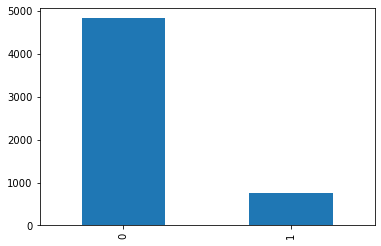

In [11]:
df['labels'].value_counts().plot.bar()

<h4 style="color:blue;" >Feature engineering(Feature Extraction) | Özellik(Değişken) Çıkarımı</h4>
<p style="color:darkblue;">Ham veri setimizdeki satır ve sutünları kullanarak bazen gerektiğinde çok işimize yaramayan verileri çıkartır veya değiştiririz. Örneğin yukarıda ham mesaj tipini '0' , spam mesaj tipini '1' olarak tanımladık. Bu örnek aslında tam olarak bu başlık altına girmesede konunun anlaşılması açısından önemi vardır.</p>
<p style="color:darkblue;">Bu başlık altında asıl olarak ilgileneceğimiz kısım yine ham veri setimizin satır ve sutünlarında bulunan verilerden yeni bir öznitelik yani yeni bir sutün elde etme işlemi olarak adlandırılabilir. Bu işlem sonucunda her zaman yeni bir öznitelik elde etmeyebilir, var olan üzerinde değişiklik yapabilir veya kullanmayacaksak bu özniteliği silebiliriz.</p>
<p style="color:darkblue;">Biz ise burada her bir satırdaki mesajlardan bunların karakter sayısını elde ederek ileride spam mesaj karakter sayısı ile ham mesaj karakter sayısı arasında bir gözlem ve bu gözleme dayalı bir öğrenme gerçekleştireceğiz.</p>

In [12]:
df['len']=df['message'].apply(len)
df

,message,labels,len
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives aro...",0,61
...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1,160
5568,Will ü b going to esplanade fr home?,0,36
5569,"Pity, * was in mood for that. So...any other s...",0,57
5570,The guy did some bitching but I acted like i'd...,0,125


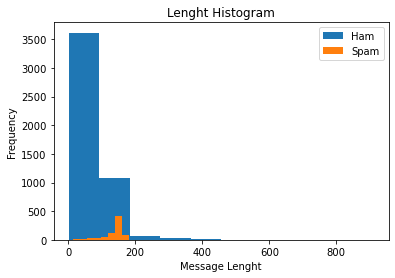

In [13]:
plt.hist(df[df['labels']==0]['len'],label="Ham")
plt.hist(df[df['labels']==1]['len'],label="Spam")
plt.title("Lenght Histogram")
plt.xlabel('Message Lenght')
plt.ylabel('Frequency')
plt.legend()

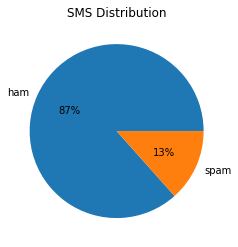

In [14]:
is_spam=pd.value_counts(df['labels'],sort=True)
is_spam.plot(kind="pie",labels=["ham", "spam"],autopct="%1.0f%%")
plt.title("SMS Distribution")
plt.ylabel("")
plt.show()

<h3 style="color:red;" >2- Veri Ön İşleme</h3>
<p style="color:darkblue;">Bu aşama elimizdeki corpus'ta yani verimizde bulunan büyük-küçük harf dönüşümleri, noktalama işaretlerinin silinmesi veya bunların her bir satır için sayısını elde ederek özellik çıkarımı yapılması, eğer gerekli ise az geçen kelimelerin silinmesi, tokenization, stemming ve lemmatization işlemlerinin yapıldığı aşamadır. Veriyi hazırlama aşaması da denilebilir.</p>

In [15]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
ps = PorterStemmer() 
message = []
for i in range(0, df.shape[0]):
    #i.split()
    review = re.sub('[^a-zA-Z]', ' ', df['message'][i]) # 1
    review = review.split() # 2
    review = [ps.stem(word.lower()) for word in review if not word in stopwords.words('english')] # 3
    review = ' '.join(review) # 4
    message.append(review) # 5
df['clean_message']=np.empty((len(message),1)) # 6
for i in range(len(message)): # 7
    df['clean_message'][i]=message[i] # 8
df['clean_message_len']=df['clean_message'].apply(len) # 9
df.head()

<ipython-input-16-ed172bd38d96>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_message'][i]=message[i] # 8
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,message,labels,len,clean_message,clean_message_len
0,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazi avail bugi n great world...,76
1,Ok lar... Joking wif u oni...,0,29,ok lar joke wif u oni,21
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entri wkli comp win fa cup final tkt st m...,101
3,U dun say so early hor... U c already then say...,0,49,u dun say earli hor u c alreadi say,35
4,"Nah I don't think he goes to usf, he lives aro...",0,61,nah i think goe usf live around though,38


<p style="color:darkblue;">Yukarıda yapılanların kafa karıştırmaması adına her satırda yanlarına verdiğim numaralar ile açıklamalar yapmak istedim. Başlamadan önce bu işlemlerde kullandığım modülleri anlatarak başlamak isterim.</p>
<p style="color:darkblue;">re(Regular Expressions | Düzenli ifadeler): Düzenli ifadeler tüm modern dillerde bulunur, dağınık bir metin içerisinde istediğimiz formattaki metinleri yakalayabilmemize imkan tanır. Mesela, bir kaynakta geçen tüm e-posta adreslerini veya içinde rakam bulunan ve gmail uzantılı olan mail adreslerini ayıklamak için kullanabilirsiniz. Düzenli ifadeler olmasaydı ardı arkasına birçok if - else yazmak gerekebilirdi. Bu modül, birkaç saatte yapabileceğiniz bir işlemi saniyeler içerisinde sizin yerinize yapabiliyor.</p>
<p style="color:darkblue;">PorterStemmer: Bu aslında bir modülden çok nltk.stem veya nltk.porter modüllerinin altındaki bir fonksiyondur. Temel görevi 'Stemming' işlevidir. Peki bu işlev nedir ? Hatırlayalım; </p>
<p style="color:darkblue;">- Bir kelimeyi köküne indirgeme işlemini yapar.(gözlük,gözler,gözlükçü gibi kelimelerin kökünün göz olduğunu bize söylemeye yarar).</p>
<p style="color:darkblue;">- Buradaki çalışmamızda ingilizce sözcükler ile çalıştığımız için kelimelerin sonundaki (-ed,-ity gibi) takıların gitmesini beklemekteyiz.</p>
<p style="color:darkblue;"> stopwords: nltk.corpus modülü altında bir fonksiyondur. Tek başına anlamı olmayan kelimelerin(the,a,with gibi) bize metin madenciliği ve doğal dil işlemede ileride kuracağımız algoritmalarımızda bir faydası yoktur hatta anlamsal olarak bir şey ifade etmedikleri için silinmezlerse algoritma ve tahminlerin doğruluk oranlarında ciddi azalmalar görülebilir. Bu sebeple bu kelimelerin tespit edilip metinden(corpustan) çıkartılması gerekmektedir. Burada bu anlamsız kelimeler dillere göre değişiklik göstereceğinden stopwords.words('english') ile işlem yapmak istediğimiz dili de seçebiliriz. </p>

<p style="color:darkblue;"> Öncelikle for döngüsünün içerisinde df'nin satır boyutu kadar bir işlem yapmak istediğimizi belirtiyoruz. Bu sayede her satırdaki mesaja ulaşabiliyoruz.
    #1 de yapılan işlem: review = re.sub('[^a-zA-Z]', ' ', df['message'][i]) ifadesinde re kütüphanesinden sub() fonksiyonunu kullanıyoruz. Bu fonksiyon içersine aldığı parametrelere göre karakterler üzerinde arama ve eşleştirme işlemlerini yapar ve string döndürür. Bu fonksiyon olmasaydı yapacağımız bu tür karakter işlemlerinde çokça if-else koşulları kullanmamız gerekecekti. Burada ise yaptığımız işlem df['message'][i]'nin içerisinden(bu ham ya da spam olan mesaj tutmakta) sadece a'dan z'ye kadar olan büyük küçük tüm harfler dahil olacak şekilde(ingilizce, yani ü,ö,ğ gibi harfler varsayılan olarak dahil değildir, bunları extra olarak bizim dahil etmemiz gerekir.) alıyoruz ve bu aldığımız metnin içerisindeki kelimeleri " " ile birleştirip eskisi gibi cümle halini koruyor fakat en önemlisi sadece a'dan z'ye karakterleri aldığımız için sayılardan ve noktalama işareti gibi işimize yaramayan karakterlerden de kurtulmuş oluyoruz. Metnin düzenlenmiş halini ise review değişkenine atıyoruz. Bu kütüphane ve bu fonksiyon sayesinde bu işlemleri sadece tek satırda yapıyoruz.
</p>
<p style="color:darkblue;"> #2 de yapılan işlem: review = review.split() ifadesi ile review içersinde o an yer alan cümlenin her kelimesini " " lara göre bölerek bir liste haline getirir. Bunu yapmamızın amacı aşağısında yapacağımız Stemmer işlemine hazırlamaktır.
</p>
<p style="color:darkblue;"> #3 de yapılan işlem: review = [ps.stem(word.lower()) for word in review if not word in stopwords.words('english')] bu satırda yine birden fazla işlemi tek satırda yapıyoruz. Öncelikle yukarıda zaten anlattığım fonksiyonlardan biri olan PorterStemmer(ps) ile burada her bir kelime için stemming işlemi yapıyoruz. Bu işlemi her kelime üzerinde yapabilmek için burada cümle içerisinde de bir döngü kurarak kelime kelime kelimelerin üzerinde geziyoruz. Bu işlem ile yukarıda da anlattığım gibi her kelimeyi köküne indirgiyor aynı zamanda her bir kelimeyi küçük harfe dönüştürüp bütün kelimleri tek bir formata indirgiyoruz. Sağ taraftaki if sorgusunda ise kelime kelime gezdiğim kelimelerden stopwords olanları yeni düzenlenmiş metnimiz olacak olan review'e dahil etmiyor hem büyük-küçük harf dönüşümü, hem stemming hem de stopwords işlemlerini tek bir satırda yapıyoruz. Bu işlemler sonucu bize liste döndürür.</p>
<p style="color:darkblue;"> #4 de yapılan işlem: review = ' '.join(review) bu işlem ile yukarıda bize liste olarak dönen review değişkenimizi aralarında " " olacak şekilde join() fonksiyonu ile birleştirip geri string değişken tipine çeviriyoruz.</p>
<p style="color:darkblue;"> #5 ve #6 de yapılan işlemler: message.append(review)-df['clean_message']=np.empty((len(message),1)) Bu iki işlemi birlikte ele almak gerekli, #5 te yukarıda oluşturduğumuz listenin içerisine review değişkenimizde bulunan her bir satırı ekleyerek listeyi dolduruyoruz. #6 da ise bu ön işleme aşamaları sonucu temiz mesajlarımız için df['clean_message']'ı oluşturup bunun içerisinde #5 te içerisine satır satır mesaj eklediğimiz liste'nin uzunluğu kadar rastgele değer atıyor bu sayede dataframi içine alacağı değerlerin tam sınırı olacak şekilde dolduruyoruz. Burada yaptığımız doldurma tamamen içerisinin dolması için yapılan bir eylemdir, içerisinde henüz daha düzenlenmiş, önişlenmiş mesajlar yoktur. Zaten df['clean_message']=np.empty((len(message),1)) işlemi döngü dışında yapıyoruz ki daha önce döngü içerisinde her satır bu listeye eklensin ve listenin sınırı belirli olsun. </p>
<p style="color:darkblue;"> #7 ve #8 yani diğer for döngüsü içerisindeki işlemler: for i in range(len(message)):df['clean_message'][i]=message[i] Buradaki temel amaç df['clean_message']'ın içerisini düzenlenmiş, işlenmiş mesajlar ile doldurmaktır. Bunun içinde mesajları zaten tutan listemizin boyutu kadar bir döngü içerisinde df['clean_message']'ın her bir satırına karşılık message listesinin içerisindeki her bir satır karşılık gelmektedir. Bu sayede önişlenmiş verilerimizi df['clean_message'] içerisine dolduruyoruz.
</p>
<p style="color:darkblue;"> #9 da yapılan işlem: df['clean_message_len']=df['clean_message'].apply(len) işleminde, tıpkı eski, önişlenmemiş mesajlarımızın uzunluğunu özellik çıkarımı yaparak bulduğumuz gibi aynı işlemi yeni, önişlenmiş mesajlarımız içinde yapıyoruz ve her satırdaki karakterlerin sayısı için ayrı bir sutün oluşturup ekliyoruz.</p>

<h3 style="color:red;" >3- Veriyi Makine Öğrenmesine Hazırlamak</h3>
<p style="color:darkblue;">Aslında bakarsak makine öğrenmesine kadar yapılan her işlem veriyi makine öğrenmesine hazırlama işlemidir. Fakat burada belirtilmek istenen durum artık veri üzerinde en son işlemlerin yapıldığı, makine öğrenme algoritmalarının sonucuda etkili olacak ayarlamaların yapıldığı ve gerektiğinde bu ayarların değiştirildiği aşamadır. 
</p>

<h4 style="color:black;" >Vectorization</h4>
<p style="color:darkblue;">Aslında bu kavramın kök tanımını açıklamak gerekirse; birçok CPU'nun aynı işlemi iki, dört veya daha fazla veriye aynı anda uygulayan "vektör" veya "SIMD" komut setleri bulunur. Modern x86 yongalarında SSE yönergeleri bulunur, birçok PPC yongasında "Altivec" yönergeleri bulunur ve hatta bazı ARM yongalarında NEON adı verilen bir vektör komut kümesi bulunur. Burada bahsi geçen "SIMD","SSE" ve "Altivec" yönergelerinin temel amacı ve hizmeti birden fazla veri nesnesi üzerinde aynı işlemlerin gerçekleştirildiği performansı artıran işlemlerdir. <a href="https://www.intel.com.tr/content/www/tr/tr/support/articles/000005779/processors.html">(Bknz)</a></p>
<p style="color:darkblue;">Vektörizasyon, skaler bir programı vektör programına dönüştürmek için kullanılan terimdir. Vektörize edilmiş programlar, tek bir komuttan birden fazla işlemi çalıştırabilirken, skaler yalnızca aynı anda işlenen çiftleri üzerinde çalışabilir.</p>

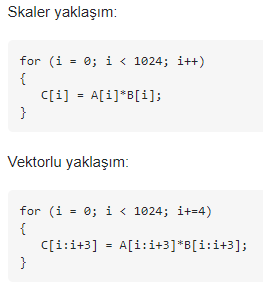

In [17]:
SVG(filename='Adsız2.svg')

<p style="color:darkblue;">Yani kısacası "Vektörizasyon", bir dizinin tek bir öğesini N kez işlemek yerine, dizinin 4 öğesini aynı anda N / 4 kez işleyecek şekilde bir döngüyü yeniden yazma işlemidir.</p>
<p style="color:darkblue;">Vektörize kodun birçok avantajı vardır, bunlar arasında:</p>
<p style="color:darkblue;">
<ul>
      <li>Vektörize edilmiş kod daha kısa ve okunması daha kolaydır.</li>
      <li>Daha az kod satırı genellikle daha az hata anlamına gelir.</li>
      <li>Vektörizasyon olmadan, kodumuz verimsiz ve döngüler için okunması zor olacaktı.</li>
</ul>
</p>
<p style="color:darkblue;">Bizim burada Vectorization'ı kullanmamızın nedeni de yukarıdaki nedenler olmakla birlikte zaten hali hazırda kullandığımız Numpy, dizileri işlemek için yerleşik python seçenekleriyle yapıldığında genellikle daha yavaş olan n boyutlu dizinin hızlı işlenmesi için vektörleştirmeyi kullanmaktadır. Bu sayede kodumuz ileride geliştireceğimiz makine öğrenmesi algoritmasını da darboğaza sokmaz ve hem işlemciyi hemde derleyici verimli halde kullanılırız.</p>


In [18]:
# Verilerimizi X,Y olarak bölyoruz. X'de modelimizi eğitmek için bulunan mesajları,
# Y'de ise bu mesajların hangi tür olduğunu tutuyoruz.
X=df["clean_message"]
X

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri wkli comp win fa cup final tkt st m...
3                     u dun say earli hor u c alreadi say
4                  nah i think goe usf live around though
                              ...                        
5567    thi nd time tri contact u u pound prize claim ...
5568                           will b go esplanad fr home
5569                                 piti mood so suggest
5570    the guy bitch i act like interest buy someth e...
5571                                    rofl it true name
Name: clean_message, Length: 5572, dtype: object

In [19]:
Y=df["labels"]
Y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: labels, Length: 5572, dtype: int64

<p style="color:darkblue;">Şimdi ise ayırdığımız X ve Y değerlerini aşağıda CountVectorizer fonksiyonu ile birlikte kullanacağız. Peki bu fonksiyon nedir, ne işe yarar ?</p>
<p style="color:darkblue;">CountVectorizer, verilen bir metni(corpusu) özelliklerin geçme sıklığı matrisine (yani vektöre) çeviren bir fonksiyondur.</p>
<p style="color:darkblue;"> cv=CountVectorizer(max_features=2500) ifadeside yer alan max_features parametresini göz önüne alalım. Bu parametre kesinlikle isteğe bağlıdır ve eldeki veri setinin içeriğine göre değerlendirilip yazılmalıdır. Burada yaptığı işlem 5571 metin arasında kelime frekanslarına bakarak en verimli, en çok 2500 kelime frekansını alır. Yani bazen tüm kelime dağarcığını dönüştürmek etkili değildir, çünkü eğer son derece nadir(frekansı az) bulunan veriler geçilirse(dönüştürülürse) gelecekte girdilere istenmeyen boyutlar katacaktır. Bu durumda uygun tekniklerden biri, corpustaki kelime frekanslarını yazdırmak ve daha sonra bunlar için belirli bir eşik belirlemek olabilir. 50'lik bir eşik belirlediğinizi ve veri topluluğunuzun 100 kelimeden oluştuğunu düşünün. Sözcük frekanslarına baktıktan sonra 20 sözcük, 50'den az kez geçiyorsa(frekansı). Böylece, max_features=80 olarak belirlemek modeliniz için daha iyi olacaktır.
</p>
<p style="color:darkblue;">Burada fit_transform().toarray() ifadesine geçmeden önce ayrı ayrı fit() ve transform() işlemlerini açıklayalım. Öncelikle bu iki fonksiyonun da temel işlevleri, eğitim ve test verilerimizi ölçeklendirirken veya standartlaştırırken kullanılmalarıdır. Ve hemen hemen her zaman birlikte kullanılırlar.</p>
<p style="color:darkblue;">fit(): Eğitim verilerinden öğrenme modeli parametreleri oluşturmak için kullanılır. Verilerimizde bulunan özelliklerin her birinin ortalamasını ve varyansını hesaplıyor.</p>
<p style="color:darkblue;">transform(): fit() yönteminden üretilen verilerin ilgili ortalama ve varyansı kullanarak tüm özellikleri dönüştürür.</p>
<p style="color:darkblue;"> fit_transform(): Eğitim verilerini ölçeklendirebilmemiz ve ayrıca bu verilerin ölçeklendirme parametrelerini öğrenebilmemiz için eğitim verilerinde fit_transform () kullanılır. Burada oluşturduğumuz model, eğitim setinin özelliklerinin ortalamasını ve varyansını öğrenecek. Öğrenilen bu parametreler daha sonra test verilerimizi ölçeklendirmek için kullanılır.</p>
<p style="color:darkblue;">Burada bilinmesi gereken önemli bir husus vardır. fit_transform() fonksiyonunu eğitim verilerimizde, transform() fonksiyonu ise test verilerimizde kullanılır. Peki neden ? Eğitim verilerini ölçeklendirebilmemiz ve ayrıca bu verilerin ölçeklendirme parametrelerini öğrenebilmemiz için eğitim verilerinde fit_transform () kullanılır. Burada oluşturduğumuz model, eğitim setinin özelliklerinin ortalamasını ve varyansını öğrenecek. Öğrenilen bu parametreler daha sonra test verilerimizi ölçeklendirmek için kullanılır. Peki aslında bu fonksiyon kendi içerisinde neler yapıyor; fit() fonsksiyonu, verilerimizde bulunan özelliklerin her birinin ortalamasını ve varyansını hesaplıyor. transform() fonksiyonu ise, ilgili ortalama ve varyansı kullanarak tüm özellikleri dönüştürüyor.
Şimdi, ölçeklendirmenin test verilerimize de uygulanmasını istiyoruz ve aynı zamanda modelimizle önyargılı olmak istemiyoruz. Test verilerimizin tamamen yeni ve modelimiz için sürpriz bir set olmasını istiyoruz. transform() fonksiyonu bu durumda bize yardımcı olur. transform() fonksiyonu kullanarak, test verilerimizi dönüştürmek için eğitim verilerimizden hesaplananla aynı ortalama ve varyansı kullanabiliriz. Bu nedenle, eğitim verilerini kullanarak modelimiz tarafından öğrenilen parametreler, test verilerimizi dönüştürmemize yardımcı olacaktır.</p>
<p style="color:darkblue;">
Yani biz eğer test verilerimizde de fit() fonksiyonu kullanırsak, her özellik için yeni bir ölçek olan yeni bir ortalama ve varyans hesaplayacağız ve modelimizin test verilerimiz hakkında bilgi edinmesine de izin vereceğiz. Bu nedenle, sürpriz olarak saklamak istediğimiz şey artık modelimiz tarafından bilinmekte olup, modelimizin makine öğrenimini kullanarak bir model oluşturmanın nihai amacı olan test (yani görünmeyen,bilinmeyen) verilerinde nasıl performans gösterdiğine dair iyi bir tahmin alamayacağız.
Bu, bir makine öğrenimi modeli oluştururken verilerimizi ölçeklendirmek için kullanılan standart prosedürdür, böylece modelimiz veri kümesinin belirli bir özelliğine yönelik önyargılı olmaz ve aynı zamanda modelimizin test verilerimizin özelliklerini, değerlerini ve eğilimleri gibi parametreleri öğrenmesini engeller.</p>



In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
cv=CountVectorizer(max_features=2500)
X=cv.fit_transform(message).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [22]:
Y=np.array(Y)
Y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

<h4 style="color:black;" >Train and Test split</h4>
<p style="color:darkblue;">Bu aşamada artık verilerimizi eğitim ve test olarak ayırıp daha sonra farklı makine öğrenme modelleri ile makine öğrenmesi geliştirerek hangisinin daha başarılı sonuçlar vereceğini gözlemleyeceğiz</p>
<p style="color:darkblue;">Bu işlem için sklearnde train_test_split() fonksiyonu bulunmaktadır. Bu fonksiyon içerisine yukarıda vektörleştirdiğimiz X ve Y ve değerlerini, test_size denilen verinin kaçta kaçını test için kullanacağımızı belirttiğimiz parametreyi ve random_state denilen bir parametre alır.</p>
<p style="color:darkblue;">random_state: Oluşturduğumuz bölmelerin yeniden üretilebilir olmasını sağlar. Scikit-learn, bölünmeleri oluşturmak için rastgele permütasyonlar kullanır. random_state, rastgele sayı oluşturucu için bir çekirdek olarak kullanılır. Bu, rastgele sayıların aynı sırada üretilmesini sağlar.Eğer kodda random_state belirtmezsek, kodumuzu her çalıştırdığımızda yeni bir rastgele değer üretilir ve eğitim ve test veri kümeleri her seferinde farklı değerlere sahip olur.
Bununla birlikte, random_state = 0, 1, 42 veya başka bir tam sayı gibi sabit bir değer atanırsa, kodumuzu kaç kez çalıştırırsak çalıştıralım, sonuç aynı kalır ve doalyısı ile eğitim ve test veri kümelerinde aynı değerler olacaktır.</p>

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [24]:
print("X_train shape: {}\n X_test shape: {}\nY_train shape: {}\nY_test shape: {}"
      .format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train shape: (4457, 2500)
 X_test shape: (1115, 2500)
Y_train shape: (4457,)
Y_test shape: (1115,)


In [25]:
acc=[]

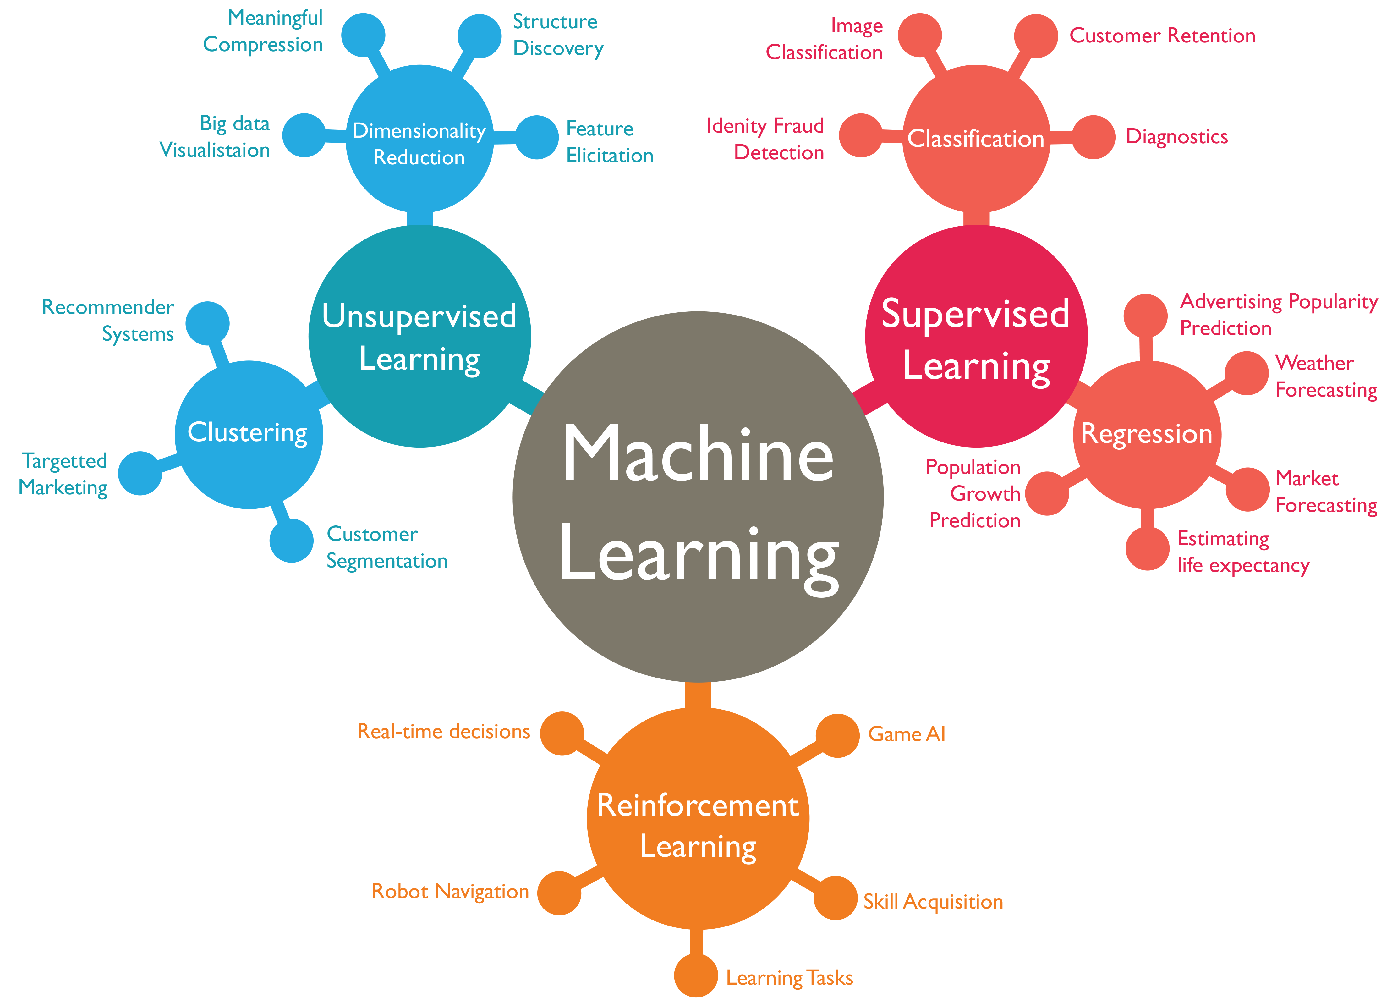

In [26]:
Image(filename = "Adsız.png", width = 700, height = 500)

<h3 style="color:red;" >4- Makine Öğrenmesi Algoritmaları ve Doğru Algoritma Seçimi</h3>


<p style="color:darkblue;">Öncelikle yukarıdaki resmi de dikkate aldığımızda burada uygulayacağımız makine öğrenmesi <b>"Supervised Learning (Denetimli Öğrenme)"</b>'dir.</p>
<p style="color:darkblue;">Denetimli Öğrenme şöyle açıklanabilir; Girdi değişkenlerini (X), çıktı değişkenlerine (Y) olmak üzere bu iki değeri eşleme işlevini öğrenmek için etiketli eğitim verileri kullanır. Denetimli öğrenme problemleri çıkışa (outputa) bağlı olarak regresyon ve sınıflandırma problemleri olarak gruplandırılabilir.</p>
<ul>
      <li><p style="color:red">Sınıflandırma:</p> Bu çalışma için sınıflandırmayı anlamlandırmak gerekirse; bir sınıflandırma probleminde, çıktı değişkeninin “spam” veya “spam değil” gibi bir kategori olması durumudur. Birçok mail örneği sınıflarıyla (spam veya değil) birlikte eğitilmiştir ve modelimiz yeni maillerin nasıl sınıflandırılacağını öğrenir.
</li>
      <li><p style="color:red">Regresyon:</p> Regresyon problemi ise, çıktı değişkeninin “tl” veya “ağırlık” gibi gerçek bir değer olduğu durumudur. Yani bir değer (genellikle sürekli olan değerler) arıyorsak, buna regresyon denir. Mesela predictors olarak adlandırılan bir dizi özellik (kilometre, yaş, marka vb.) verildiğinde, bir otomobilin fiyatı gibi bir sayısal değer tahmin etmektir. İşte bu tür bir göreve regresyon denir. Bir sistemi eğitmek için, hem özellikler dizisi(predictors) hem de etiketler (label) dahil olmak üzere birçok araba örneği vermemiz gerekmektedir.
</li>
</ul>
<p style="color:darkblue;">Bazı regresyon algoritmalarının sınıflandırma için de kullanılabileceğini ve sınıflandırma algoritmalarının da regresyon için kullanılabileceğini unutmamalıyız. Örneğin, Lojistik Regresyon, belirli bir sınıfa ait olma olasılığına karşılık gelen bir değer (Buradaki örneğimizdeki gibi ham-spam sınıflandırması) olabileceğinden, sınıflandırma için yaygın olarak kullanılır.</p>

<p style="color:darkblue;">En önemli denetimli öğrenme algoritmalarından bazıları:</p>
<ul>
      <li><p style="color:red"><b>k-Nearest Neighbors(En Yakın Komşuluk)</b></p>K-en yakın komşuluk (KNN) algoritması, uygulaması kolay gözetimli öğrenme algoritmalarındandır. Hem sınıflandırma hem de regresyon problemlerinin çözümünde kullanılır. Algoritma, sınıfları belli olan bir örnek kümesindeki verilerden yararlanılarak kullanılmaktadır. Örnek veri setine katılacak olan yeni verinin, mevcut verilere göre uzaklığı hesaplanıp, k sayıda yakın komşuluğuna bakılır. KNN; eski, basit ve gürültülü eğitim verilerine karşı dirençli olması sebebiyle en popüler makine öğrenme algoritmalarından biridir. Fakat bunun yanında dezavantajı da mevcuttur. Örneğin, uzaklık hesabı yaparken bütün durumları sakladığından, büyük veriler için kullanıldığında çok sayıda bellek alanına gereksinim duymaktadır.</li>
      <li><p style="color:red"><b>Logistic Regression</b></p>Lojistik regresyon, ikili sonuç veren binary değişkenlerin modellenmesinde kullanılmaktadır. İkili durum söz konusu olan modellerde sonuç genellikle 0 veya 1 olarak tanımlanmaktadır. Örnek vermek gerekirse tıpkı bizim veri setimizde ham grubunu 0, spam grubunu 1 olarak tanımlamamız. Bu durumda p, örneklem kümesindeki 1'lerin, q ise sıfırların oranını vermektedir. Kısacası tıpkı diğer lojistik regresyon yöntemiyle kullanılan örneklemlerin hangi sınıfa ait olduklarını belirleyebiliriz.
</li>
      <li><p style="color:red"><b>Linear Regression</b></p>Linear regresyon, farklı değişkenler arasındaki ilişkiyi modellemek için kullanılan en temel tekniktir. Çoğunlukla karmaşık analizlerin ilk basamağını oluşturmaktadır. Linear yani doğrusal regresyon bize normal dağılmış, hakkında veri toplanmış iki değişken arasında doğrusal ilişki olup olmadığını test etme olanağı verir. Değişkenlerden biri tahmin, biri sonuç değişkenidir.</li>
      <li><p style="color:red"><b>Support Vector Machines (SVMs) (Destek Vektör Makineleri)</b></p> Destek Vektör Makineleri istatiksel öğrenme teorisine dayalı bir gözetimli öğrenme algoritmasıdır. Temel olarak iki sınıfa ait verileri birbirinden en uygun şekilde ayırmak için kullanılır. Bunun için karar sınırları yada diğer bir ifadeyle hiper düzlemler belirlenir. DVM’ler günümüzde yüz tanıma sistemlerinden, ses analizine kadar birçok sınıflandırma probleminde kullanılmaktadırlar.</li>
      <li><p style="color:red"><b>Decision Trees and Random Forests</b></p> Aslında burada 'Random Forests' grubu da bir karar ağacı olduğu için hem biraz karar ağaçlarının yapısından daha sonra random forests algoritmasından söz edeceğiz. Ağaç tabanlı öğrenme algoritmaları, en çok kullanılan gözetimli öğrenme algorimalarındandır. Genel itibariyle ele alınan bütün problemlerin (sınıflandırma ve regression) çözümüne uyarlanabilirler. Fakat bu model kayıp değerleri desteklememektedir, bu değerleri önce düzenlememiz, duruma göre ortalama ya da en çok tekrar eden değer gibi değer atamaları yapmamız gerekmektedir. Karar ağacı algoritması, veri madenciliği sınıflandırma algoritmalarından biridir. Önceden tanımlanmış bir hedef değişkene sahiplerdir. Yapıları itibariyle en tepeden en aşağı inen bir strateji sunmaktadırlar. Bir karar ağacı, çok sayıda kayıt içeren bir veri kümesini, bir dizi karar kuralları uygulayarak daha küçük kümelere bölmek için kullanılan bir yapıdır. Yani basit karar verme adımları uygulanarak, büyük miktarlardaki kayıtları, çok küçük kayıt gruplarına bölerek kullanılan bir yapıdır. Buradaki önemli husus, karar ağaçlarının en büyük problemlemi aşırı öğrenme, veriyi ezberlemedir(overfitting). İşte tam bu noktada devereye 'Random Forests' girmektedir. Random forests modeli bu problemi çözmek için hem veri setinden hem de öznitelik setinden rastgele olarak 10'larca 100'lerce farklı alt setler seçiyor ve bunları eğitiyor. Bu yöntemle 100'lerce karar ağacı oluşturuluyor ve her bir karar ağacı bireysel olarak tahminde bulunuyor. Günün sonunda problemimiz regresyonsa karar ağaçlarının tahminlerinin ortalamasını, problemimiz sınıflandırmaysa tahminler arasında en çok oy alan etiketi seçiyoruz. Şimdi bütün bunları basit bir örnekle açıklayacak olursak: Örneğin bu akşam güzel bir film izlemek istiyorsunuz ve kafanız karışık. Bir arkadaşınızı ararsanız ve o size tercih ettiğiniz film türü, süre, yıl, oyuncu-yönetmen, hollywood-alternatif vs. soru setinden çeşitli sorularla daha önce izlediğiniz filmlere (training set) göre bir tahminde bulunursa bu karar ağacı olur. Eğer 20 arkadaşınız bu soru setinden farklı sorular seçip verdiğiniz cevaplara göre tavsiyede bulunursa ve siz en çok tavsiye edilen filmi seçerseniz bu random forests modelimiz olur. Random forests modelinde farklı veri setleri üzerinde eğitim gerçekleştiği için varyans, diğer bir deyişle karar ağaçlarının en büyük problemlerinden olan overfitting azalır. Random forest modelinin diğer bir özelliği bize özniteliklerin ne kadar önemli olduğunu vermesi. (Bir özniteliğin önemli olması demek o özniteliğin bağımlı değişkendeki varyansın açıklanmasına ne kadar katkı yaptığıyla alakalı bir durumdur.) Random forest algoritmasına x sayıda öznitelik verip en faydalı y tanesini seçmesini isteyebiliriz ve istersek bu bilgiyi istediğimiz başka bir modelde kullanabiliriz.</li>
      <li><p style="color:red"><b>Naive Bayes</b></p>Bu algoritma, koşullu olasılıklara dayanarak hedef sınıftaki belirli bir değerin gerçekleşmesi ihtimalini inceler ve buna dayalı olarak hedef sınıfın değerini tahmin eder. Bu hesaplama Bayes Formülü aracılığı ile gerçekleştirilir. Naive Bayes algoritması sonuç olarak hedef sınıfın hangi değerinin gerçekleşme olasılığının ne olduğunu bildirir. Bir defa sistem eğitildikten sonra oldukça performanslı çalışsa da sistemin ilk kez eğitilmesi veya eğitilmiş bir sistemin güncellenmesi için yeniden eğitilmesi ise zaman ve kaynak kullanımı anlamında maliyetlidir. Çünkü tüm veri kümesini her sınıflandırma işlemi için tekrar tekrar taraması gerekir. Naive Bayes algoritması Metin Madenciliğine (Text Classification ve Multinomial Naive Bayes) ve Çoklu Sınıf Tahminlerine (Multi Class Prediction) elverişlidir.

</li>
</ul>

<p style="color:darkblue">Şimdi, yukarıda anlattığımız algoritmaları uygulayabilmek için sklearn kütüphanemizin içerisinden kullanacağımız modül ve fonksiyonları dahil edelim.</p>

In [27]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

<h4 style="color:black;" >Ortak parametreler ve fonksiyonlar</h4>
<p style="color:darkblue">Öncelikle her algoritmada kullanılan bir ortak fonksiyona değinerek başlamak isterim. <b>".predict"</b> fonksiyonu bizim modelimizi eğitmemizin için daha önce yukarıda vektörize ettiğimiz X değişkenininin (yani özelliklerin geçme sıklığı matrisine çevirdiğimiz) bizim belirttiğimiz(%20) aralıkta test olarak ayırdığımız veri grubunu içerisine parametre olarak yolluyoruz. Bu sayede X_test olarak belirlediğimiz veri grubundaki her bir örnek için sınıf değerleri tahmini yapılır(bu tahminler eğitim olaral yolladığımız veriler sayesinde yapılmaktadır) ve bu fonksiyon bize sınıf değerleri döndürür.(yani bu işlem sonucundan 0 ham ya da 1 spam olarak değer döndürür).</p> <p style="color:darkblue">Daha sonra yine bütün algoritmalar bu işlemden sonra y_test olarak belirlediğimiz veri grubu ile ".predict" fonksiyonu sonrası bize sınıf olarak dönen değerleri eşleyerek doğruluk oranını karşımıza sunar. Tabi bu eşleştirme kısmı ".predict" fonksiyonunun görevi değildir. Bu zaten yukarıda da anlattığım gibi her sınıflandırma algoritmasının altında yatan bir işlevdir. Burada önemli olan nokta verilerimizi test ve eğitim olarak bölerken ya da her algoritmanın kendine has parametrelerini verirken yapacağımız değişiklikler sonucunda algoritma ve sonuç üzerinde olan etkisinin gözlemidir. Veriyi 0.20 bölmek ile 0.40 bölmek bize çok farklı sonuçlar verecektir. Genellikle araştırmalarda 0.20-0.30 arasında bölme yapılır. Bu aralıktaki her değer için sonuç üzerinde etki incelenmeli ve en verimlisi kullanılmalıdır.</p>
</p> <p style="color:darkblue">Mesela aşağıda KNN algoritmasına has olan, içerisine aldığı <b>"n_neighbors"</b>  parametresi bulunmaktadır. Bu parametre; yeni gelen verinin eski verilere ya da veriye olan uzaklığı olarak anlamlandırılır. Ve bu değer bize yeni gelen verinin eski verilerden kaç tanesine komşu, kaç tanesine bakılarak bir etkikete sahip olacağı anlamına gelir. Bu değere 1 vermek ile 5 vermek çok farklı sonuçlar görmemize yol açacaktır. Burada da yine değer denemesi yapılarak en başarılı sonucu veren değer tercih edilmeli ve model bunun üzerine kurulmalıdır. </p>
</p> <p style="color:darkblue">Bir diğer ortak fonksiyonumuz <b>"accuracy_score()"</b> fonksiyonudur. Bu fonksiyon ise içerisine aldığı tahmin değeri ve sınıf değerlerini birbiri ile eşlemesi sonucu çıkan doğruluk değerini bize sunar.</p>

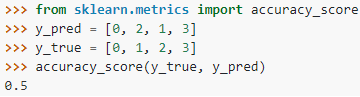

In [28]:
SVG(filename='Adsız4.svg')

</p> <p style="color:darkblue">Örnekte de görüldüğü üzere eşlemeyi yapmış ve doğruluk değerini default olarak normalize bir şekilde bize sunmuştur. Eğer normalize değer istemiyorsak normalize=False yazmamız yeterlidir.</p>

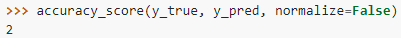

In [29]:
SVG(filename='Adsız3.svg')

</p> <p style="color:darkblue">Gelelim bir diğer ortak fonksiyonumuz olan <b>"confusion_matrix()"</b> fonksiyonuna. Bu fonksiyon bize içerisine aldığı tahmin ve sınıf etiketleri üzerinde yaptığı eşlemeleri komşuluk matrisi şeklinde gösterir. Yani bir tarafta doğru bildiği değerleri öteki tarafta doğru bilemediği değerleri olacak şekilde bize adet bazında gösterim yapar.</p>
</p> <p style="color:darkblue">Sırada <b>"classification_report()"</b> fonksiyonu var. Bu fonksiyon bize modelin başarısı hakkındaki tüm detayları ve incelikleri vermektedir. kullanımı çok basit olduğu gibi bir o kadar da kullanışlı ve göze hitap eden bir fonksiyondur. İçerisinde "precision", "recall", "f1-score" ve "support" başlık değerleri vardır. </p>
<ul><li><p style="color:red"> <b>Precision</b></p>Precision bize her sınıf için yapılan tahminlerin normalize değerlerini sunar. Yani veri setimizin ilk algoritması ile bunu anlatacak olursam 955 tane ham mesaj arasından modelimiz sadece 3 tanesini spam olarak tahmin etmiş ve %98 olarak spam mesajları tahmin etmede başarılı. Tabi burada değerlerimizi normalize olduğundan 1 üzerinden 0.98 başarımız bulunmaktadır. Buradaki değerler etiketlerin sayısı ile değişim göstermektedir. Yani biz burada 955 veri içerisinden 3 tanesi yanlış olduğu için 0.98 değerini aldık eğer bu veri daha az veya daha çok olsaydı bu hassasiyet de buna göre değişecekti.</li>
    <li><p style="color:red"> <b>Recall</b></p> Recall 'ın tam anlamı scikit-learn.org' da 'sezgisel olarak sınıflandırıcının tüm pozitif örnekleri bulma yeteneğidir.' olarak tanımlanmıştır. Fakat üzerinde yaptığım işlemler sonucu bu değerin komşuluk matrisinde yer alan ham ve spam değerlerin doğru ve yanlış adet sayıları arasındaki orantı olduğunu gördüm. Mesela yine aşağıdaki örnekten devam edelim. Görüldüğü gibi spam mesajların arasıdan 32 değer yanlış 128 değer doğru olarak hesaplanmış. Elimizde 160 tane değer var ve bu 160 değer içerisinden 128 değer doğru tahmin edilmiş. Buradan 128/160=0.80' gelmekte. Bu değer bizim doğru tahmin hassasiyetimiz. Diğerleri için yukarıda uyguladığım işlemleri uyguladığınızda sizde doğru olduğunu göreceksiniz.</li>

 <li><p style="color:red"> <b>F1-score</b></p>F1-score basitçe bize precision ve recall değerlerinin harmonik ortalamasını veren bir değerdir. Her sınıfa karşılık gelen score değerleri, diğer tüm sınıflara kıyasla o belirli sınıftaki veri noktalarını sınıflandırmada sınıflandırıcının doğruluğunu bize söyler.</li>
 <li><p style="color:red"> <b>Support</b></p>Support değeri o sınıfta yer alan veri adetini bize gösterir. Örneğin aşağıda 0 olarak tanımladığımız ham mesaj grubunda 955 veri bulunmaktadır.</li>
</ul>

Daha fazla bilgi edinmek için <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html">bakabilirsiniz</a>.

In [30]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print('KNN Accuracy: {}\n'.format(accuracy_score(y_test, pred)))
print('-'*100)
print("Confusion Matrix \n",confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
acc.append(metrics.accuracy_score(y_test,pred))

KNN Accuracy: 0.968609865470852

----------------------------------------------------------------------------------------------------
Confusion Matrix 
 [[955   0]
 [ 35 125]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       955
           1       1.00      0.78      0.88       160

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



<p style="color:darkblue">Logistic Regression ' un içerisine aldığı önemli bir parametre olan <b>solver</b> bizim aslında doğrudan bizim veri setimizle alakalıdır. Bu algoritmanın veri setiyle olan optimizasyonunu belirler. Ve aslında altında bir matematik; türevler, fonksiyonlar, paraboller ile hesaplanan bir yaklaşım yatmadır. Kısacası elimizdeki veri seti fazla büyük değilse 'liblinear' iyi bir seçimdir. Çoklu sınıflandırma problemlerinde 'newton-cg', 'sag', 'saga' and 'lbfgs' 'liblibear' a göre daha başarılıdır.</p>
<p style="color:darkblue">Detaylı bilgi ve altında yatan matematik yaklaşımı için <a href="https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions">bakabilirsiniz.</a> Ayrıca  kendi sitesindeki tanıma da <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">buradan</a> göz atabilirisiniz.</p>

In [31]:
LR=LogisticRegression(solver='liblinear')
LR.fit(X_train,y_train)
yhat = LR.predict(X_test)
print("LogisticRegression's Accuracy: {}\n".format(metrics.accuracy_score(y_test, yhat)))
print('-'*100)
print("Confusion Matrix \n", confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))
acc.append(metrics.accuracy_score(y_test,yhat))

LogisticRegression's Accuracy: 0.9829596412556054

----------------------------------------------------------------------------------------------------
Confusion Matrix 
 [[954   1]
 [ 18 142]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       955
           1       0.99      0.89      0.94       160

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



<p style="color:darkblue">Svm's algoritmasının içerisine aldığı çekirdek fonksiyonu olarak tanımlayabileceğimiz <b>kernel</b> parametresi bulunmaktadır. İçerisine 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' olmak üzere 5 farklı yaklaşım alabilmektedir. Bu yaklaşımların hepsinin kendi içerisinde matematiksel hesapları ve incelikleri bulunmaktadır. Ama kullandığımız 'rbf' yi anlatmak gerekirse; bir SVM modelini Radyal Temel Fonksiyonu (RBF) çekirdeği ile eğitirken, iki parametre dikkate alınmalıdır: C ve gamma. C Tüm SVM çekirdeklerinde ortak olan parametre, eğitim örneklerinin yanlış sınıflandırmasını karar yüzeyinin basitliğine karşı değiştirir. Düşük C, karar yüzeyini pürüzsüzleştirir, yüksek C ise tüm eğitim örneklerini doğru şekilde sınıflandırmayı amaçlar. Gamma tek bir eğitim örneğinin model üzerinde ne kadar etkisi olduğunu tanımlar. Gamma ne kadar büyükse, diğer örneklerin etkilenmesi o kadar fazla(yakın) olmalıdır.
Doğru C ve gamma seçimi SVM'nin performansı için çok önemlidir.</p>
<p style="color:darkblue">Detaylı bilgi ve altında yatan matematik yaklaşımı için <a href="https://scikit-learn.org/stable/modules/svm.html#svm-kernels">buraya</a> ve <a href="https://scikit-learn.org/stable/modules/svm.html">buraya</a> göz atabilirisiniz.</p>

In [32]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
print("SVM's Accuracy:{0}".format(metrics.accuracy_score(y_test, yhat)))
print('-'*100)
print("Confusion Matrix \n", confusion_matrix(y_test, yhat))
print(classification_report(y_test, yhat))
acc.append(metrics.accuracy_score(y_test, yhat))


SVM's Accuracy:0.9856502242152466
----------------------------------------------------------------------------------------------------
Confusion Matrix 
 [[955   0]
 [ 16 144]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       955
           1       1.00      0.90      0.95       160

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [33]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
pred = dtree.predict(X_test)
print('Decision Tree Accuracy: {} \n'.format(accuracy_score(y_test, pred)))
print('-'*100)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
acc.append(metrics.accuracy_score(y_test, pred))

Decision Tree Accuracy: 0.9775784753363229 

----------------------------------------------------------------------------------------------------
[[943  12]
 [ 13 147]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       955
           1       0.92      0.92      0.92       160

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



<p style="color:darkblue">Random forest algoritmasının içerisnde bulunan ve bize oluşturulmak istenen ağaç sayısını belirten <b>n_estimators</b> parametresi sayesinde oluşturmak istediğimiz ağaç sayılarını belirleyip algoritmayı buna göre şekillendirebiliyoruz. Buradaki bu değeri ne kadar arttırırsak o kadar iyi performans alabiliriz. Tabi bu veri setinin büyüklüğü ile de alakalı bir durumdur. Sonuçta bu ağaç sayılarını arttırmanın da bir maliyeti vardır ve kodumuzu oldukça yavaşlatabilir. Bu yüzden veri setiyle optimize olacak şekilde ayarlanmalıdır. </p>
<p style="color:darkblue">Daha detaylı bilgi için <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#:~:text=A%20random%20forest%20is%20a,accuracy%20and%20control%20over%2Dfitting.&text=Changed%20in%20version%200.22%3A%20The,10%20to%20100%20in%200.22.">buraya</a> bakabilirsiniz.

In [34]:
Random_forest = RandomForestClassifier(n_estimators=50,random_state=0)
Random_forest.fit(X_train,y_train)
randomForest_predict = Random_forest.predict(X_test)
randomForest_score = metrics.accuracy_score(y_test, randomForest_predict)
print("Random Forest Score :",randomForest_score)
print('-'*100)
print("Confusion Matrix \n", confusion_matrix(y_test, randomForest_predict))
print(classification_report(y_test, randomForest_predict))
acc.append(metrics.accuracy_score(y_test, randomForest_predict))

Random Forest Score : 0.9838565022421525
----------------------------------------------------------------------------------------------------
Confusion Matrix 
 [[954   1]
 [ 17 143]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       955
           1       0.99      0.89      0.94       160

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



In [35]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
pred = mnb.predict(X_test)
print('Naive Bayes Accuracy: {} \n'.format(accuracy_score(y_test, pred)))
print('-'*100)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
acc.append(metrics.accuracy_score(y_test, pred))

Naive Bayes Accuracy: 0.9856502242152466 

----------------------------------------------------------------------------------------------------
[[947   8]
 [  8 152]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       955
           1       0.95      0.95      0.95       160

    accuracy                           0.99      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.99      0.99      0.99      1115



Text(0, 0.5, 'Accuracy')

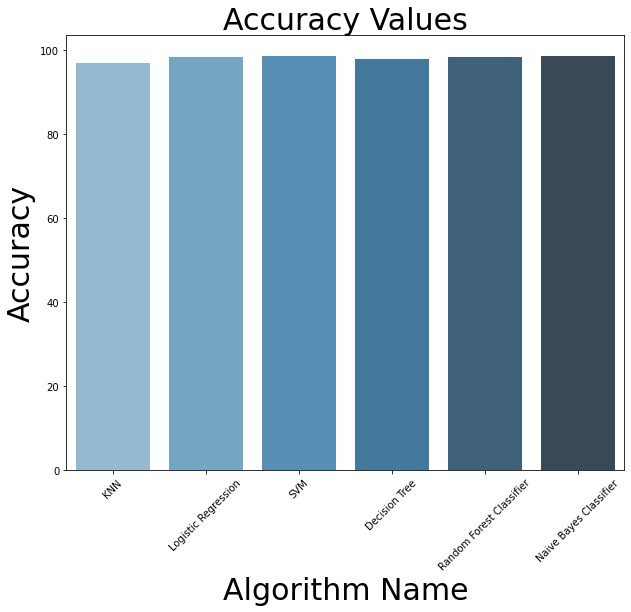

In [36]:
algo_name=['KNN','Logistic Regression','SVM','Decision Tree','Random Forest Classifier','Naive Bayes Classifier']
acc=np.array(acc)
from numpy import median
plt.figure(figsize=(10,8))
sns.barplot(y=acc*100,x=algo_name,estimator=median,palette="Blues_d")
plt.title("Accuracy Values",size=30)
plt.xlabel('Algorithm Name',size=30)
plt.xticks(rotation=45)
plt.ylabel('Accuracy',size=30)

</p> <p style="color:darkblue">Görüldüğü üzere algoritmaların hepsi birbirine yakın sonuçlar vermekle beraber <b>Naive Bayes ve SVM's</b> algoritması 0.9856502242152466 değeri ile en başarılı algoritma olmuştur. Fakat dikkat edilmesi gereken şey Navie Bayes algoritması hem ham mesaj tahmininde hem de spam mesaj tahmininde 8 adet yanlış tahmin yapmış(8 ham,8 spam toplam 16 yanlış tahmin) fakat SVM's algoritması sadece spam mesaj tahmininde 16 yanlış yaparak ham mesajların hepsini doğru tahmin etmiştir. Burada komşuluk matrisi sayesinde gördüğümüz önemli bir nokta var aslında. Bu da şöyledir ki bundan sonraki mesaj tahminlerinde biz ham mesaj tahmini için SVM's algoritmasını spam mesaj tahmini için Navie Bayes algoritmasını kullanabiliriz. Bu ayrımı komşuluk matrisi olmasa yapamayabilirdik. Bakıldığı zaman homojenliği bakımından Navie Bayes biraz daha ön planda durmaktadır. Komşuluk matrisi sayesinde algoritmalarımızı amaçlar doğrultusunda yukarıda verdiğim örnekteki gibi de kullanabiliriz.</p>
<p style="color:darkblue">Aşağıya algoritmamızı test etmek için kendi oluşturduğumuz metni girip türünü doğru tahmin etmesini isteyebiliriz. Bu sayede yaptığımız modelinde aktif bir kullanımını gözlemleyebiliriz.</p>

In [37]:
def sms(text):
    lab = ['ham','spam'] 
    x = cv.transform(text).toarray()
    pred = Random_forest.predict(x)
    s = [str(i) for i in pred]
    a = int("".join(s))
    result = str("Mesaj türü: "+ lab[a])
    print(result)
sms(["""FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from 
     your phone now! ubscribe6GBP/ mnth inc 3hrs 16 stop?txtStop"""])
sms(["""MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H*"""])
sms(["""What you doing? how are you? """]) 
sms(["""URGENT! Your Mobile No 07808726822 was awarded a L2,000 Bonus Caller Prize on 02/09/03!
This is our 2nd attempt to contact YOU! Call 0871-872-9758 BOX95QU"""])

Mesaj türü: spam
Mesaj türü: ham
Mesaj türü: ham
Mesaj türü: spam
